In [6]:
# import packages

import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Data Loading and Preprocessing
---

In [32]:
# load datasets 

for i in range(19): #for 0 and 1
    df = pd.read_csv('daliac/dataset_' + str(i+1) + '.txt', sep=',', header=None)

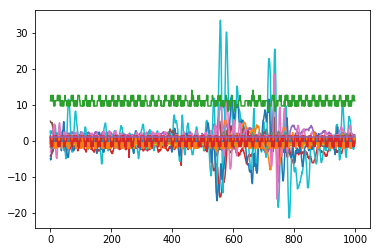

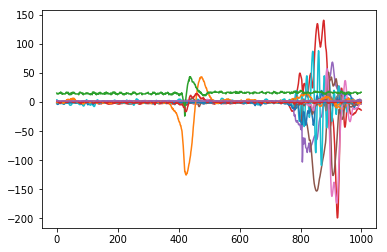

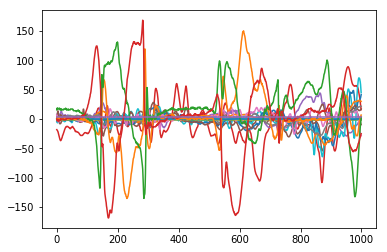

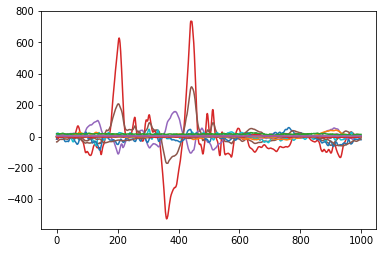

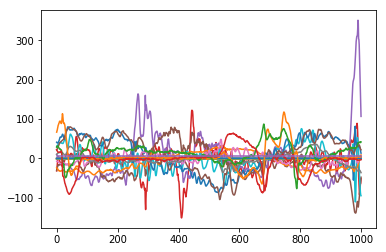

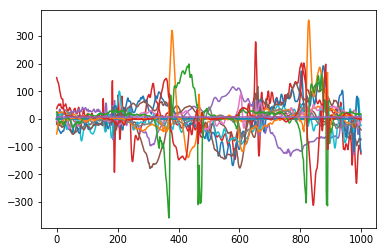

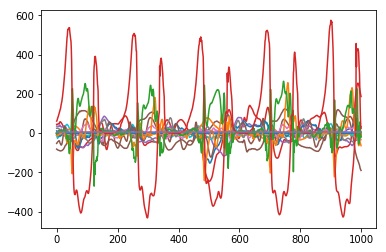

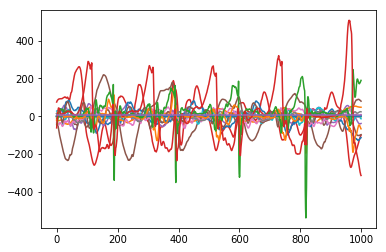

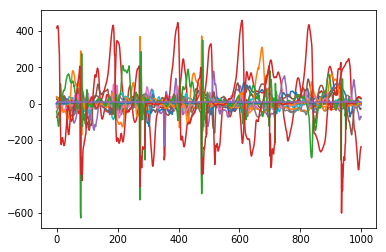

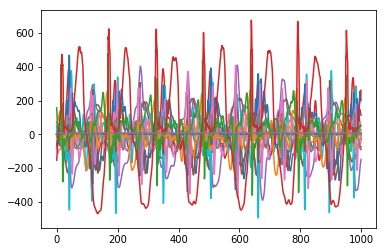

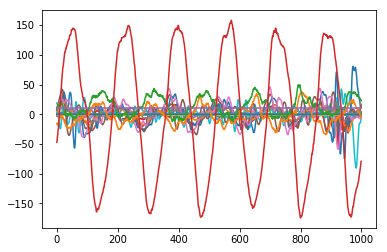

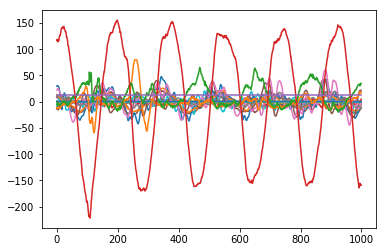

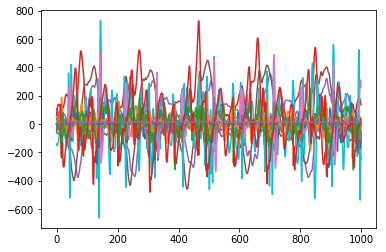

In [80]:
# Visualise data

for i in range(1,14):
    df_sitting = df[df[24] == i].values
    plt.plot(df_sitting[500:1500, :])
    plt.show()